# NDVI Heatmap

In [1]:
## Import libraries and useful functions

suppressMessages({
  library(ggplot2)
  library(terra)
  library(leaflet)
  library(tidyr)
  library(dplyr)
  library(htmlwidgets)
})

library(ggplot2)
library(terra)
library(leaflet)
library(tidyr)
library(dplyr)
library(htmlwidgets)

source("../scripts/utils.R")
source("../scripts/visualize.R")

### Main parameters defined by user (country, spatial resolution, date to inspect)

In [2]:
country_name <- "Zambia"
resolution <- 100 # in meters
map_year <- 2024
map_month <- 12

### Set paths and define additional parameters

In [3]:
data_type <- "NDVI"

# Input NVDI basemaps stored in country folder. 
data_path <- paste0("../data/", data_type, "/", country_name, "/", resolution, "m_resolution/")
# Area of Interest (AoI) files in AoI folder
aoi_path <- "../data/AoI/"

# define date for which to load data 
map_date <- as.Date(paste(map_year, map_month, 1, sep="-"))


In [4]:
map_date

[1] "2024-12-01"

### Get list of relevant filenames

In [5]:
# NDVI filenames
ndvi_files <- get_filenames(filepath = data_path, data_type = data_type, 
                            file_extension = ".tif", country_name = country_name)

# AoI filenames
aoi_files <- get_filenames(filepath = aoi_path, data_type = "AoI", 
                           file_extension = ".geojson", country_name = country_name)


Loading NDVI data for Zambia 

Loading AoI data for Zambia 


### Subselect filenames according to date

In [6]:
# get NDVI filenames dataframe (includes date info)
files_df <- get_filename_df(ndvi_files = ndvi_files)

# Given date selected, split file into test data and train data
# test filenames
test_files_df <- files_df[(files_df$dates == map_date),]

# get train filenames (same month, all years prior to test date)
train_files_df <- files_df[(files_df$dates< map_date & months(files_df$dates) %in% month.name[map_month]),]

### Load raster and vector objects - Aoi, train data and test data

In [7]:
# load input Area of Interest (AoI) to later mask data
aoi_proj <- get_aoi_vector(aoi_files = aoi_files, aoi_path = aoi_path,
                           projection = "EPSG:4326")

test_ndvi_msk <- get_ndvi_raster(ndvi_files = test_files_df$filenames, data_path = data_path,
                            projection = "EPSG:4326", dates = test_files_df$dates,
                            aoi_proj = aoi_proj)

train_ndvi_msk <- get_ndvi_raster(ndvi_files = train_files_df$filenames, data_path = data_path,
                            projection = "EPSG:4326", dates = train_files_df$dates,
                            aoi_proj = aoi_proj)


Reading layer `AoI_Mponda' from data source 
  `/home/user/data/AoI/AoI_Zambia_By_Life_Connected.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 26.77027 ymin: -15.1321 xmax: 26.92342 ymax: -14.85555
Geodetic CRS:  WGS 84


In [8]:
# Extract raster layers for each date
# and store in dataframe
test_ndvi_df <- get_ndvi_df(ndvi_rast = test_ndvi_msk, dates = test_files_df$dates) 
train_ndvi_df <- get_ndvi_df(ndvi_rast = train_ndvi_msk, dates = train_files_df$dates) 

### Inspect NDVI values for the selected month, throughout the years

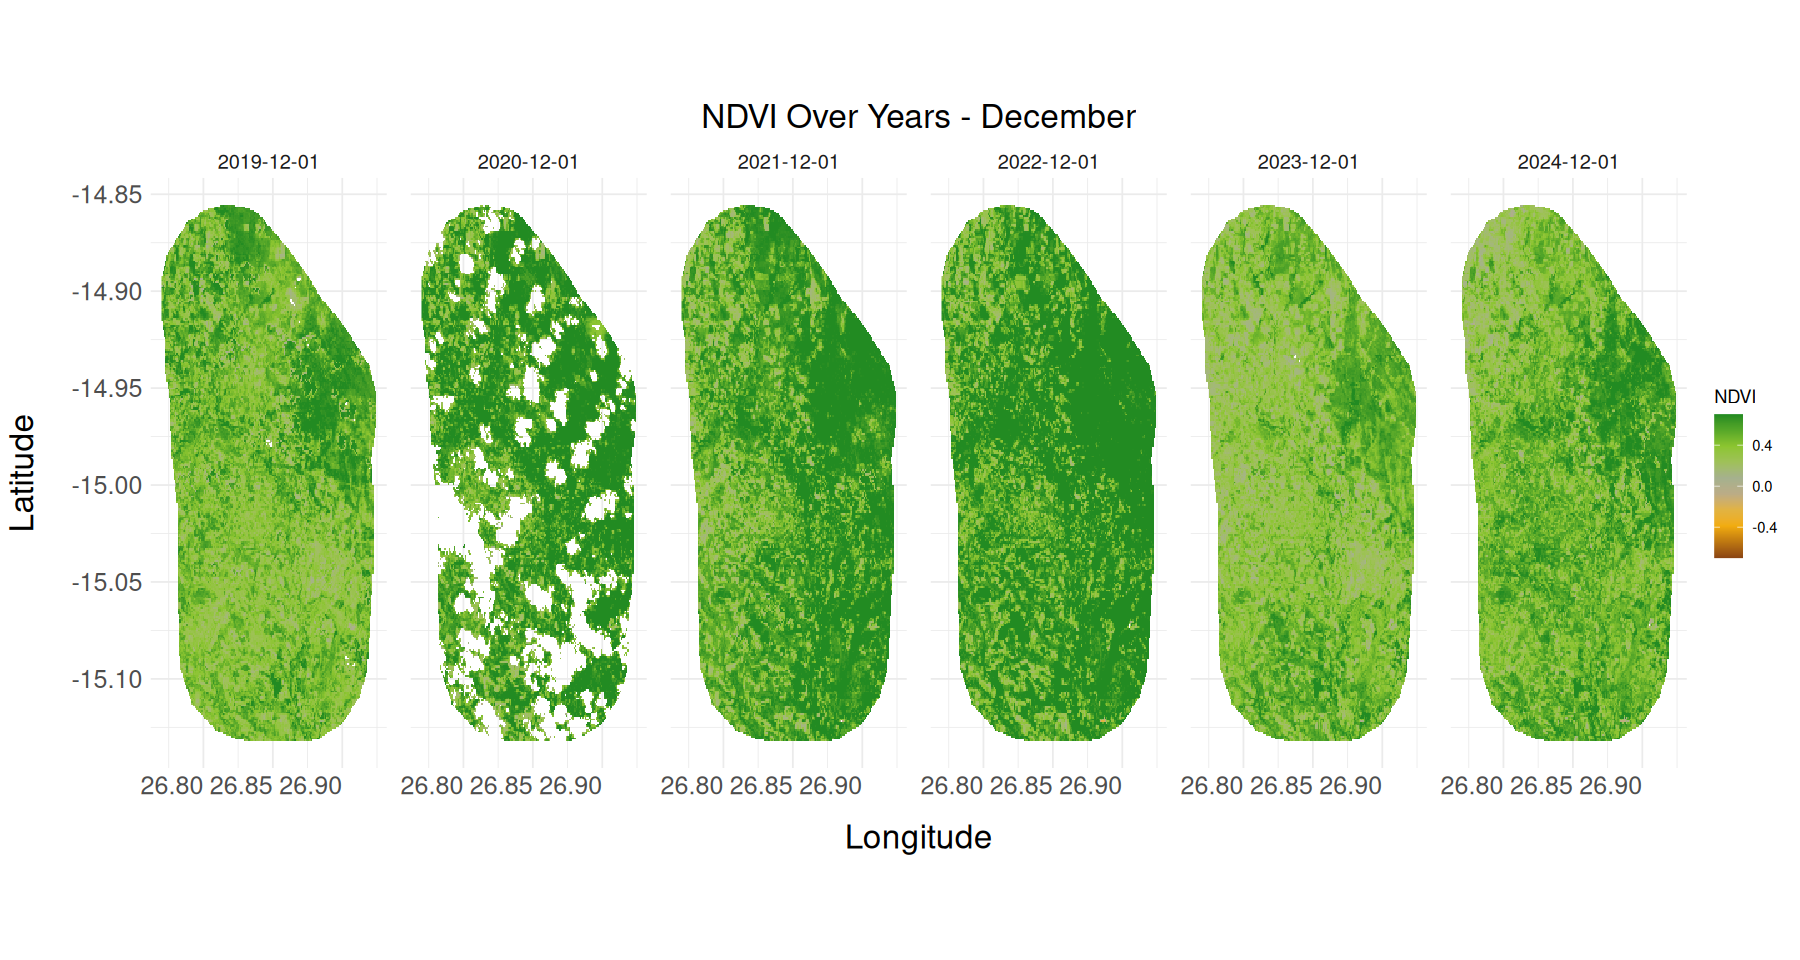

In [9]:
## Plot one month of raster data, over years
ndvi_maps <- plot_ndvi_maps(data = bind_rows(train_ndvi_df,test_ndvi_df), 
                            month_to_plot = sprintf("%02d", map_month), #"03",
                            plot_width = 15, 
                            plot_height = 8,
                            zlim_range = c(-0.7, 0.7), 
                            ncol = dim(train_files_df)[1] + 1,
                            save_path = NULL, 
                            filename = paste0(country_name, "_", 
                                              resolution, "m_",
                                              "NDVI_maps.png")
                            )
ndvi_maps

In [10]:
## compute NDVI deviation from baseline in 2D space
delta_ndvi_df <- get_delta_ndvi_df(train_ndvi_df = train_ndvi_df, 
                                   test_ndvi_df = test_ndvi_df)

`summarise()` has grouped output by 'x', 'y'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'x', 'y'. You can override using the
`.groups` argument.


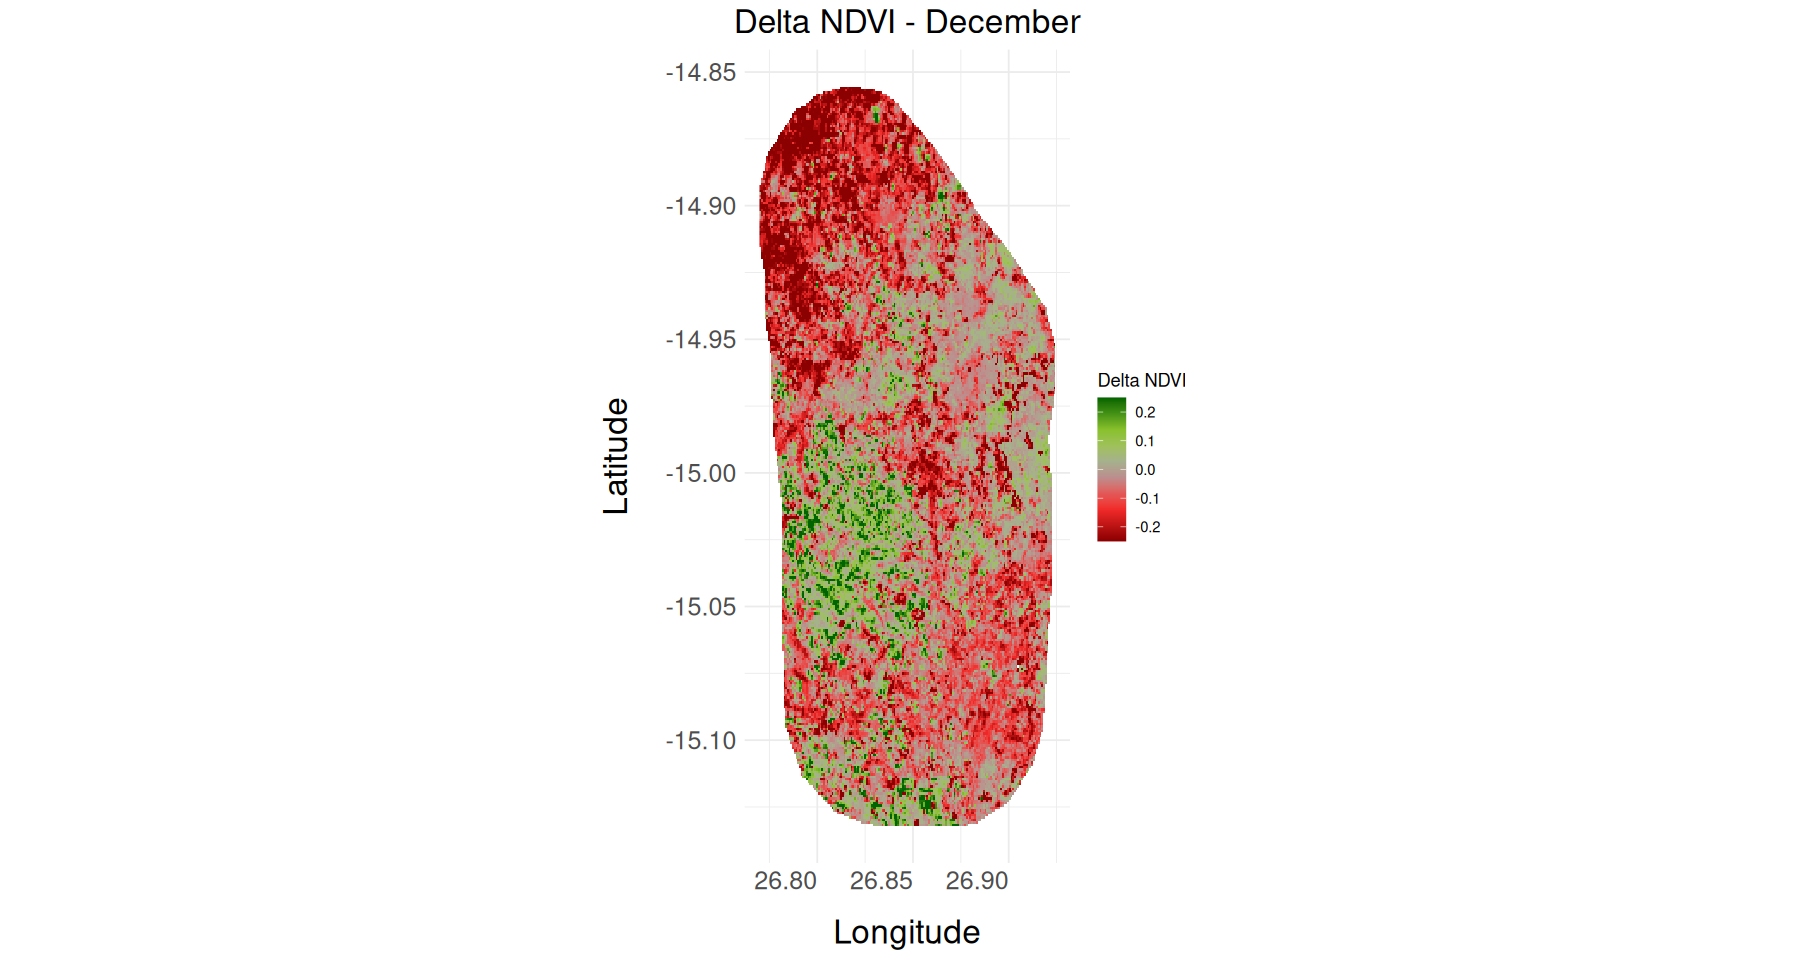

In [11]:
## Plot one month of raster data, to show delta NDVI

delta_ndvi_map <- plot_delta_ndvi_map(data = delta_ndvi_df, 
                            month_to_plot = sprintf("%02d", map_month), #"03",
                            plot_width = 15, 
                            plot_height = 8,
                            zlim_range = c(-.25, .25), 
                            save_path = NULL, 
                            filename = paste0(country_name, "_", 
                                              resolution, "m_",
                                              "deltaNDVI_map.png")
                            )
delta_ndvi_map

### Plot delta NDVI over street view

In [12]:
# Show leaflet plot
map <- plot_delta_ndvi_streetview(data = delta_ndvi_df, 
                                  month_to_plot = sprintf("%02d", map_month),
                                  save_path = NULL, 
                                  filename = "deltaNDVI_heatmap.html")
map  # Display the map

HTML widgets cannot be represented in plain text (need html)